## Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import glob, os, pickle

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import load_model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

os.chdir('/workspace/Padchest/MOCAE_Base-master/MOC-AE_Code')
from dataset.dataset_padchest import *
from utils.metrics import *
from models.dl_blocks import *

In [2]:
global config

with open('/workspace/Padchest/MOCAE_Base-master/MOC-AE_Code/config.json', 'r') as f:
    config = json.load(f)

In [3]:
LABELS = sorted(config["padchest"]["label_names"], key=config["padchest"]["label_names"].get)
LABELS

['cardiomegaly', 'aortic elongation', 'scoliosis', 'normal']

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


## Load from pickle

In [4]:
data = Dataset(config)

with open(config["PATHS"]["IMAGES_PATH"] + "data_padchest_4labels_cropped_undersampling.pkl", 'rb') as f:
    data = pickle.load(f)

In [7]:
print(f'X_train shape: {np.shape(data.X_train)}, y_train shape: {np.shape(data.y_train)}')
print(f'X_val shape: {np.shape(data.X_val)}, y_val shape: {np.shape(data.y_val)}')

X_train shape: (6146, 224, 224, 1), y_train shape: (6146, 4)
X_val shape: (682, 224, 224, 1), y_val shape: (682, 4)


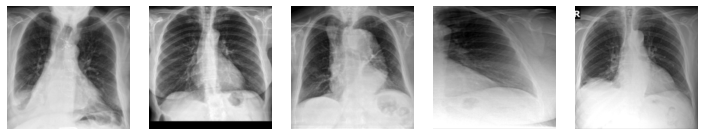

In [8]:
n_images = 5

fig, axes = plt.subplots(1, n_images, figsize=(n_images * 2, 2))

for i in range(n_images):
    img = data.X_train[i].squeeze()  
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')  

plt.tight_layout()
plt.show()

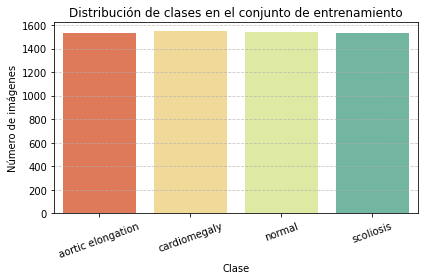

In [6]:
y_train = data.y_train

if len(y_train.shape) > 1:
    y_train = y_train.argmax(axis=1)

label_map = {
    0: "cardiomegaly",      
    1: "aortic elongation",     
    2: "scoliosis",      
    3: "normal"    
}

labels_text = pd.Series(y_train).map(label_map)

df = pd.DataFrame({'Etiqueta': labels_text})

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Etiqueta', palette='Spectral', order=sorted(label_map.values()))

plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Evaluation functions

In [5]:
def plot_train_val(history, complementary_metric="accuracy"):
    # X axis definition
    x_axis = range(len(history['loss']))

    # Define figure
    plt.rcParams['figure.figsize'] = [20, 5]
    f, ax = plt.subplots(1, 2, sharex=False, sharey=False)

    # Plot complete loss figure
    ax[0].plot(x_axis, history['loss'], label='Train Loss')
    ax[0].plot(x_axis, history['val_loss'], label='Validation Loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('iteration')
    ax[0].legend(loc="upper right")
    ax[0].grid()
    
    ax[1].plot(x_axis, history[complementary_metric], label='Train '+complementary_metric)
    ax[1].plot(x_axis, history['val_'+complementary_metric], label='Validation '+complementary_metric)
    ax[1].set_title(complementary_metric)
    ax[1].set_xlabel('iteration')
    ax[1].legend(loc="upper right")
    ax[1].grid()
    
    # Save figure
    plt.show()

In [6]:
def plot_conf_mat(y_pred, y_val, names):
    f, ax = plt.subplots(1, figsize=(5, 5))

    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True,
                cmap='Blues', fmt = 'd', ax=ax, cbar=False)

    ax.set_ylabel("Real label")
    ax.set_xlabel("Predicted label")
    
    names = [os.path.basename(path) for path in names]
    
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    ax.xaxis.set_ticklabels(names)
    ax.set_yticklabels(ax.get_yticks(), rotation = 45)
    ax.yaxis.set_ticklabels(names)

    plt.show()

    print(classification_report(y_val, y_pred))

## Results with 10 iterations

### Train configuration

In [5]:
batch_size = 64
epochs = 10
val_perc = 0.1

In [6]:
n_imgs = 1000
n_it = 10

In [7]:
base_path = '/workspace/Padchest/MOCAE_Base-master/results_training'

### Classifier

In [8]:
tf.get_logger().setLevel('ERROR')  

accuracy_classifier = []
f1_score_classifier = []
recall_classifier = []
precision_classifier = []

for i in range(1, n_it + 1):
    model_path = os.path.join(base_path, f'Classifier_{i}', 'models/')

    encoder = load_model(os.path.join(model_path, 'e_best_encoder.h5'), custom_objects={'sampling': sampling})
    classifier = load_model(os.path.join(model_path, 'e_best_classifier.h5'), custom_objects={'sampling': sampling})

    lat_space = encoder.predict(data.X_val[:n_imgs])

    y_real = data.y_val[:n_imgs]
    if len(y_real.shape) > 1:
        y_real = np.argmax(y_real, axis=1)

    y_pred = classifier.predict(lat_space)
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)

    report = classification_report(y_real, y_pred, output_dict=True)
    accuracy_classifier.append(report['accuracy'])
    f1_score_classifier.append(report['macro avg']['f1-score'])
    recall_classifier.append(report['macro avg']['recall'])
    precision_classifier.append(report['macro avg']['precision'])

In [14]:
print("-"*5, 'Classifier', "-"*5)
print("accuracy: " + str(np.mean(accuracy_classifier)))
print("f1_score: " + str(np.mean(f1_score_classifier)))
print("recall: " + str(np.mean(recall_classifier)))
print("precision: " + str(np.mean(precision_classifier)))

----- Classifier -----
accuracy: 0.4939882697947214
f1_score: 0.46754637252721987
recall: 0.5008087318441092
precision: 0.5504789533336869


### MOCVAE

In [9]:
tf.get_logger().setLevel('ERROR')  

accuracy_mocvae = []
f1_score_mocvae = []
recall_mocvae = []
precision_mocvae = []

for i in range(1, n_it + 1):
    model_path = os.path.join(base_path, f'MOCVAE_{i}', 'models/')

    encoder = load_model(model_path + 'e_best_encoder.h5', custom_objects={'sampling': sampling})
    classifier = load_model(model_path + 'e_best_classifier.h5', custom_objects={'sampling': sampling})

    lat_space = encoder.predict(data.X_val[:n_imgs])
    z_mean, z_log_sigma, z = lat_space
    lat_space = z  

    y_real = data.y_val[:n_imgs]
    if len(y_real.shape) > 1:
        y_real = np.argmax(y_real, axis=1)

    y_pred = classifier.predict(lat_space)
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)

    report = classification_report(y_real, y_pred, output_dict=True)
    accuracy_mocvae.append(report['accuracy'])
    f1_score_mocvae.append(report['macro avg']['f1-score'])
    recall_mocvae.append(report['macro avg']['recall'])
    precision_mocvae.append(report['macro avg']['precision'])

In [23]:
print("-"*5, 'MOCVAE', "-"*5)
print("accuracy: " + str(np.mean(accuracy_mocvae)))
print("f1_score: " + str(np.mean(f1_score_mocvae)))
print("recall: " + str(np.mean(recall_mocvae)))
print("precision: " + str(np.mean(precision_mocvae)))

----- MOCVAE -----
accuracy: 0.5375366568914955
f1_score: 0.5277663632627008
recall: 0.5422838193370463
precision: 0.5513029299683878


### EfficientNetB0

In [ ]:
accuracy_efficientnet = []
f1_score_efficientnet = []
recall_efficientnet = []
precision_efficientnet = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_efficientnet = tf.keras.applications.EfficientNetB0(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_efficientnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_efficientnet.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_efficientnet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_efficientnet.append(report['accuracy'])
    f1_score_efficientnet.append(report['macro avg']['f1-score'])
    recall_efficientnet.append(report['macro avg']['recall'])
    precision_efficientnet.append(report['macro avg']['precision'])
    
    model_path = f'{base_path}/EfficientNetB0/EfficientNetB0_{i}.h5'
    model_efficientnet.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [10]:
model_dir = os.path.join(base_path, 'EfficientNetB0')

accuracy_efficientnet = []
f1_score_efficientnet = []
recall_efficientnet = []
precision_efficientnet = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'EfficientNetB0_{i}.h5')

    model_efficientnet = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_efficientnet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_efficientnet.append(report['accuracy'])
    f1_score_efficientnet.append(report['macro avg']['f1-score'])
    recall_efficientnet.append(report['macro avg']['recall'])
    precision_efficientnet.append(report['macro avg']['precision'])

In [14]:
print("-"*5, 'EfficientNetB0', "-"*5)
print("accuracy: " + str(np.mean(accuracy_efficientnet)))
print("f1_score: " + str(np.mean(f1_score_efficientnet)))
print("recall: " + str(np.mean(recall_efficientnet)))
print("precision: " + str(np.mean(precision_efficientnet)))

----- EfficientNetB0 -----
accuracy: 0.4887096774193548
f1_score: 0.4718031186079368
recall: 0.4905068152627915
precision: 0.5280710133222977


### DenseNet201

In [ ]:
accuracy_densenet = []
f1_score_densenet = []
recall_densenet = []
precision_densenet = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_densenet = tf.keras.applications.DenseNet201(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_densenet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_densenet.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_densenet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_densenet.append(report['accuracy'])
    f1_score_densenet.append(report['macro avg']['f1-score'])
    recall_densenet.append(report['macro avg']['recall'])
    precision_densenet.append(report['macro avg']['precision'])
    
    model_path = f'{base_path}/DenseNet201/DenseNet201_{i}.h5'
    model_densenet.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [ ]:
model_dir = os.path.join(base_path, 'DenseNet201')

accuracy_densenet = []
f1_score_densenet = []
recall_densenet = []
precision_densenet = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'DenseNet201_{i}.h5')

    model_densenet = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_densenet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_densenet.append(report['accuracy'])
    f1_score_densenet.append(report['macro avg']['f1-score'])
    recall_densenet.append(report['macro avg']['recall'])
    precision_densenet.append(report['macro avg']['precision'])

In [18]:
print("-"*5, 'DenseNet201', "-"*5)
print("accuracy: " + str(np.mean(accuracy_densenet)))
print("f1_score: " + str(np.mean(f1_score_densenet)))
print("recall: " + str(np.mean(recall_densenet)))
print("precision: " + str(np.mean(precision_densenet)))

----- DenseNet201 -----
accuracy: 0.5890029325513197
f1_score: 0.5810952644200031
recall: 0.5902434034837948
precision: 0.6300303848998177


### VGG19

In [ ]:
accuracy_vgg19 = []
f1_score_vgg19 = []
recall_vgg19 = []
precision_vgg19 = []

for i in range(1,n_it+1):
    print('It:', str(i), datetime.now())
    model_vgg19 = tf.keras.applications.VGG19(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_vgg19.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_vgg19.fit(np.array(data.X_train), np.array(data.y_train), epochs=epochs, batch_size=batch_size,
                        validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_vgg19.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_vgg19.append(report['accuracy'])
    f1_score_vgg19.append(report['macro avg']['f1-score'])
    recall_vgg19.append(report['macro avg']['recall'])
    precision_vgg19.append(report['macro avg']['precision'])
    
    model_path = f'{base_path}/VGG19/VGG19_{i}.h5'
    model_vgg19.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [ ]:
model_dir = os.path.join(base_path, 'VGG19')

accuracy_vgg19 = []
f1_score_vgg19 = []
recall_vgg19 = []
precision_vgg19 = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'VGG19_{i}.h5')

    model_vgg = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_vgg.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_vgg19.append(report['accuracy'])
    f1_score_vgg19.append(report['macro avg']['f1-score'])
    recall_vgg19.append(report['macro avg']['recall'])
    precision_vgg19.append(report['macro avg']['precision'])

In [17]:
print("-"*5, 'VGG19', "-"*5)
print("accuracy: " + str(np.mean(accuracy_vgg19)))
print("f1_score: " + str(np.mean(f1_score_vgg19)))
print("recall: " + str(np.mean(recall_vgg19)))
print("precision: " + str(np.mean(precision_vgg19)))

----- VGG19 -----
accuracy: 0.24340175953079174
f1_score: 0.09787735849056603
recall: 0.25
precision: 0.060850439882697935


### ResNet50

In [ ]:
accuracy_resnet = []
f1_score_resnet = []
recall_resnet = []
precision_resnet = []

for i in range(1, n_it + 1):
    print('It:', str(i), datetime.now())
    model_resnet = tf.keras.applications.ResNet50(
        weights=None, input_shape=(224, 224, 1), classes=4)
    model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
    history = model_resnet.fit(np.array(data.X_train), np.array(data.y_train), 
                               epochs=epochs, batch_size=batch_size,
                               validation_split=val_perc, callbacks=[callback], verbose=0)

    y_pred = np.argmax(model_resnet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)
    
    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_resnet.append(report['accuracy'])
    f1_score_resnet.append(report['macro avg']['f1-score'])
    recall_resnet.append(report['macro avg']['recall'])
    precision_resnet.append(report['macro avg']['precision'])

    model_path = f'{base_path}/ResNet50/ResNet50_{i}.h5'
    model_resnet.save(model_path)
    print(f'Modelo guardado en: {model_path}')

In [13]:
model_dir = os.path.join(base_path, 'ResNet50')

accuracy_resnet = []
f1_score_resnet = []
recall_resnet = []
precision_resnet = []

for i in range(1, n_it + 1):
    model_path = os.path.join(model_dir, f'ResNet50_{i}.h5')
    
    model_resnet = tf.keras.models.load_model(model_path)

    y_pred = np.argmax(model_resnet.predict(np.array(data.X_val[:n_imgs])), axis=1)
    y_val = np.argmax(data.y_val[:n_imgs], axis=1)

    report = classification_report(y_val, y_pred, output_dict=True)
    accuracy_resnet.append(report['accuracy'])
    f1_score_resnet.append(report['macro avg']['f1-score'])
    recall_resnet.append(report['macro avg']['recall'])
    precision_resnet.append(report['macro avg']['precision'])

In [19]:
print("-"*5, 'ResNet50', "-"*5)
print("accuracy: " + str(np.mean(accuracy_resnet)))
print("f1_score: " + str(np.mean(f1_score_resnet)))
print("recall: " + str(np.mean(recall_resnet)))
print("precision: " + str(np.mean(precision_resnet)))

----- ResNet50 -----
accuracy: 0.4892961876832844
f1_score: 0.46503322039624423
recall: 0.4890501962167134
precision: 0.5567750103878637


## Summary of the results

In [26]:
df = pd.DataFrame(index=['Classifier', 'MOCVAE', 'EfficientNetB0', 'DenseNet201', 'VGG19', 'ResNet50'],
                  columns=['accuracy', 'f1-score', 'recall', 'precision'])

df.at['Classifier', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_classifier)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_classifier))
df.at['MOCVAE', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_mocvae))
df.at['EfficientNetB0', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_efficientnet))
df.at['DenseNet201', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_densenet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_densenet))
df.at['VGG19', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_vgg19))
df.at['ResNet50', 'accuracy'] = "{:.2f}".format(np.mean(accuracy_resnet)) + '$\pm$' + "{:.2f}".format(np.std(accuracy_resnet))

df.at['Classifier', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_classifier)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_classifier))
df.at['MOCVAE', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_mocvae))
df.at['EfficientNetB0', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_efficientnet))
df.at['DenseNet201', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_densenet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_densenet))
df.at['VGG19', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_vgg19))
df.at['ResNet50', 'f1-score'] = "{:.2f}".format(np.mean(f1_score_resnet)) + '$\pm$' + "{:.2f}".format(np.std(f1_score_resnet))

df.at['Classifier', 'recall'] = "{:.2f}".format(np.mean(recall_classifier)) + '$\pm$' + "{:.2f}".format(np.std(recall_classifier))
df.at['MOCVAE', 'recall'] = "{:.2f}".format(np.mean(recall_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(recall_mocvae))
df.at['EfficientNetB0', 'recall'] = "{:.2f}".format(np.mean(recall_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(recall_efficientnet))
df.at['DenseNet201', 'recall'] = "{:.2f}".format(np.mean(recall_densenet)) + '$\pm$' + "{:.2f}".format(np.std(recall_densenet))
df.at['VGG19', 'recall'] = "{:.2f}".format(np.mean(recall_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(recall_vgg19))
df.at['ResNet50', 'recall'] = "{:.2f}".format(np.mean(recall_resnet)) + '$\pm$' + "{:.2f}".format(np.std(recall_resnet))

df.at['Classifier', 'precision'] = "{:.2f}".format(np.mean(precision_classifier)) + '$\pm$' + "{:.2f}".format(np.std(precision_classifier))
df.at['MOCVAE', 'precision'] = "{:.2f}".format(np.mean(precision_mocvae)) + '$\pm$' + "{:.2f}".format(np.std(precision_mocvae))
df.at['EfficientNetB0', 'precision'] = "{:.2f}".format(np.mean(precision_efficientnet)) + '$\pm$' + "{:.2f}".format(np.std(precision_efficientnet))
df.at['DenseNet201', 'precision'] = "{:.2f}".format(np.mean(precision_densenet)) + '$\pm$' + "{:.2f}".format(np.std(precision_densenet))
df.at['VGG19', 'precision'] = "{:.2f}".format(np.mean(precision_vgg19)) + '$\pm$' + "{:.2f}".format(np.std(precision_vgg19))
df.at['ResNet50', 'precision'] = "{:.2f}".format(np.mean(precision_resnet)) + '$\pm$' + "{:.2f}".format(np.std(precision_resnet))

In [27]:
pd.set_option('display.max_colwidth', None)
df.head(5)

,accuracy,f1-score,recall,precision
Classifier,0.49$\pm$0.05,0.47$\pm$0.06,0.50$\pm$0.05,0.55$\pm$0.02
MOCVAE,0.54$\pm$0.03,0.53$\pm$0.03,0.54$\pm$0.03,0.55$\pm$0.02
EfficientNetB0,0.49$\pm$0.05,0.47$\pm$0.05,0.49$\pm$0.05,0.53$\pm$0.03
DenseNet201,0.50$\pm$0.06,0.46$\pm$0.08,0.50$\pm$0.07,0.60$\pm$0.05
VGG19,0.24$\pm$0.00,0.10$\pm$0.00,0.25$\pm$0.00,0.06$\pm$0.00


In [28]:
from tabulate import tabulate

print(tabulate(df, tablefmt="latex_raw"))

\begin{tabular}{lllll}
\hline
 Classifier     & 0.49$\pm$0.05 & 0.47$\pm$0.06 & 0.50$\pm$0.05 & 0.55$\pm$0.02 \\
 MOCVAE         & 0.54$\pm$0.03 & 0.53$\pm$0.03 & 0.54$\pm$0.03 & 0.55$\pm$0.02 \\
 EfficientNetB0 & 0.49$\pm$0.05 & 0.47$\pm$0.05 & 0.49$\pm$0.05 & 0.53$\pm$0.03 \\
 DenseNet201    & 0.50$\pm$0.06 & 0.46$\pm$0.08 & 0.50$\pm$0.07 & 0.60$\pm$0.05 \\
 VGG19          & 0.24$\pm$0.00 & 0.10$\pm$0.00 & 0.25$\pm$0.00 & 0.06$\pm$0.00 \\
 ResNet50       & 0.49$\pm$0.08 & 0.47$\pm$0.11 & 0.49$\pm$0.08 & 0.56$\pm$0.04 \\
\hline
\end{tabular}


### Gráfica de comparación entre f1-score y accuracy y precision

In [14]:
df_plot = pd.DataFrame({
    'Modelo': ['Classifier'] * len(accuracy_classifier) +
              ['MOCVAE'] * len(accuracy_mocvae) +
              ['EfficientNetB0'] * len(accuracy_efficientnet) +
              ['DenseNet201'] * len(accuracy_densenet) +
              ['VGG19'] * len(accuracy_vgg19) +
              ['ResNet50'] * len(accuracy_resnet),
    
    'Accuracy': accuracy_classifier + accuracy_mocvae + accuracy_efficientnet +
                accuracy_densenet + accuracy_vgg19 + accuracy_resnet,
    
    'F1-score': f1_score_classifier + f1_score_mocvae + f1_score_efficientnet +
                f1_score_densenet + f1_score_vgg19 + f1_score_resnet,
    
    'Precision': precision_classifier + precision_mocvae + precision_efficientnet +
                 precision_densenet + precision_vgg19 + precision_resnet,
    
    'Recall': recall_classifier + recall_mocvae + recall_efficientnet +
              recall_densenet + recall_vgg19 + recall_resnet
})

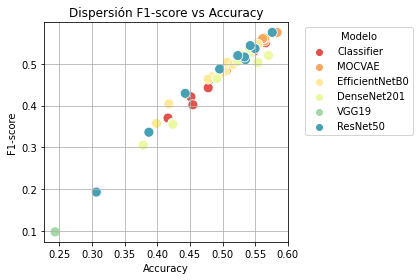

In [15]:
# F1 vs Accuracy
sns.scatterplot(data=df_plot, x='Accuracy', y='F1-score', hue='Modelo', palette='Spectral', s=100)
plt.title('Dispersión F1-score vs Accuracy')
plt.grid(True)
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

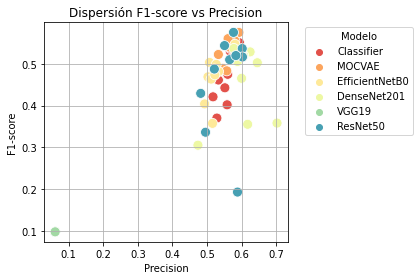

In [16]:
# F1 vs Precision
sns.scatterplot(data=df_plot, x='Precision', y='F1-score', hue='Modelo', palette='Spectral', s=100)
plt.title('Dispersión F1-score vs Precision')
plt.grid(True)
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Wilcoxon rank-sum Classifier

In [29]:
from scipy.stats import ranksums

In [33]:
print("\n-----Accuracy-----\n")

stat, p_value = ranksums(accuracy_classifier, accuracy_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_classifier, accuracy_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_classifier, accuracy_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_classifier, accuracy_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----F1 score-----\n")

stat, p_value = ranksums(f1_score_classifier, f1_score_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_classifier, f1_score_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_classifier, f1_score_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_classifier, f1_score_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Recall-----\n")

stat, p_value = ranksums(recall_classifier, recall_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_classifier, recall_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_classifier, recall_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_classifier, recall_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Precision-----\n")

stat, p_value = ranksums(precision_classifier, precision_efficientnet)
print(f"Classifier - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_classifier, precision_densenet)
print(f"Classifier - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_classifier, precision_vgg19)
print(f"Classifier - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_classifier, precision_resnet)
print(f"Classifier - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")


-----Accuracy-----

Classifier - EfficientNetB0: statistic=-0.1890, p-value=0.8501
Classifier - DenseNet201: statistic=-0.3024, p-value=0.7624
Classifier - VGG19: statistic=3.7796, p-value=0.0002
Classifier - ResNet50: statistic=-0.2268, p-value=0.8206

-----F1 score-----

Classifier - EfficientNetB0: statistic=-0.2268, p-value=0.8206
Classifier - DenseNet201: statistic=0.1512, p-value=0.8798
Classifier - VGG19: statistic=3.7796, p-value=0.0002
Classifier - ResNet50: statistic=-0.6047, p-value=0.5453

-----Recall-----

Classifier - EfficientNetB0: statistic=0.0000, p-value=1.0000
Classifier - DenseNet201: statistic=-0.1512, p-value=0.8798
Classifier - VGG19: statistic=3.7796, p-value=0.0002
Classifier - ResNet50: statistic=-0.0756, p-value=0.9397

-----Precision-----

Classifier - EfficientNetB0: statistic=1.9654, p-value=0.0494
Classifier - DenseNet201: statistic=-2.8725, p-value=0.0041
Classifier - VGG19: statistic=3.7796, p-value=0.0002
Classifier - ResNet50: statistic=-0.6803, p-v

### Wilcoxon rank-sum MOCVAE

In [31]:
print("\n-----Accuracy-----\n")

stat, p_value = ranksums(accuracy_mocvae, accuracy_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(accuracy_mocvae, accuracy_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----F1 score-----\n")

stat, p_value = ranksums(f1_score_mocvae, f1_score_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(f1_score_mocvae, f1_score_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Recall-----\n")

stat, p_value = ranksums(recall_mocvae, recall_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(recall_mocvae, recall_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\n-----Precision-----\n")

stat, p_value = ranksums(precision_mocvae, precision_efficientnet)
print(f"MOCVAE - EfficientNetB0: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_densenet)
print(f"MOCVAE - DenseNet201: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_vgg19)
print(f"MOCVAE - VGG19: statistic={stat:.4f}, p-value={p_value:.4f}")
stat, p_value = ranksums(precision_mocvae, precision_resnet)
print(f"MOCVAE - ResNet50: statistic={stat:.4f}, p-value={p_value:.4f}")


-----Accuracy-----

MOCVAE - EfficientNetB0: statistic=2.4190, p-value=0.0156
MOCVAE - DenseNet201: statistic=1.1717, p-value=0.2413
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=1.4741, p-value=0.1405

-----F1 score-----

MOCVAE - EfficientNetB0: statistic=2.2678, p-value=0.0233
MOCVAE - DenseNet201: statistic=2.3434, p-value=0.0191
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=1.3607, p-value=0.1736

-----Recall-----

MOCVAE - EfficientNetB0: statistic=2.3434, p-value=0.0191
MOCVAE - DenseNet201: statistic=1.5875, p-value=0.1124
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=1.6630, p-value=0.0963

-----Precision-----

MOCVAE - EfficientNetB0: statistic=2.2678, p-value=0.0233
MOCVAE - DenseNet201: statistic=-2.7213, p-value=0.0065
MOCVAE - VGG19: statistic=3.7796, p-value=0.0002
MOCVAE - ResNet50: statistic=-0.8315, p-value=0.4057


### All values

In [32]:
#Security values
model_names = ['Classifier', 'MOCVAE', 'EfficientNetB0', 'DenseNet201', 'VGG19', 'ResNet50']

print("\n-----Accuracies-----\n")
for i, acc in enumerate([accuracy_classifier, accuracy_mocvae, accuracy_efficientnet, accuracy_densenet, accuracy_vgg19, accuracy_resnet]):
    print(model_names[i])
    print(acc)

print("\n-----f1-scores-----\n")
for i, f1 in enumerate([f1_score_classifier, f1_score_mocvae, f1_score_efficientnet, f1_score_densenet, f1_score_vgg19, f1_score_resnet]):
    print(model_names[i])
    print(f1)

print("\n-----Recall-----\n")
for i, rec in enumerate([recall_classifier, recall_mocvae, recall_efficientnet, recall_densenet, recall_vgg19, recall_resnet]):
    print(model_names[i])
    print(rec)

print("\n-----Precisions-----\n")
for i, pre in enumerate([precision_classifier, precision_mocvae, precision_efficientnet, precision_densenet, precision_vgg19, precision_resnet]):
    print(model_names[i])
    print(pre)


-----Accuracies-----

Classifier
[0.45161290322580644, 0.5483870967741935, 0.5659824046920822, 0.4941348973607038, 0.47947214076246336, 0.41642228739002934, 0.5, 0.5513196480938416, 0.45454545454545453, 0.4780058651026393]
MOCVAE
[0.5425219941348973, 0.5879765395894428, 0.5263929618768328, 0.5395894428152492, 0.5366568914956011, 0.4970674486803519, 0.5527859237536656, 0.5439882697947214, 0.48533724340175954, 0.5630498533724341]
EfficientNetB0
[0.5073313782991202, 0.5029325513196481, 0.4838709677419355, 0.5161290322580645, 0.532258064516129, 0.5542521994134897, 0.4780058651026393, 0.39882697947214074, 0.49560117302052786, 0.4178885630498534]
DenseNet201
[0.5439882697947214, 0.3782991202346041, 0.5703812316715543, 0.5410557184750733, 0.4237536656891496, 0.4912023460410557, 0.5293255131964809, 0.4237536656891496, 0.5542521994134897, 0.5234604105571847]
VGG19
[0.2434017595307918, 0.2434017595307918, 0.2434017595307918, 0.2434017595307918, 0.2434017595307918, 0.2434017595307918, 0.24340175